<a href="https://colab.research.google.com/github/Tikhon239/dul_2021/blob/hw10/Homework/hw10/Homework10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 339 (delta 100), reused 78 (delta 60), pack-reused 163
Receiving objects: 100% (339/339), 55.19 MiB | 41.46 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=25374 sha256=e27ac75120756c1cc6ed5c6a2b4bdd94d54894d7dfb7ccfafb378064c75a0c39
  Stored in directory: /tmp/pip-ephem-wheel-cache-r0p166_e/wheels/55/59/29/0fb1c6356521

In [1]:
from typing import Tuple, List, Optional
from tqdm.auto import trange

import numpy as np

import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal

import torchvision.transforms as T

In [2]:
from dul_2021.utils.hw10_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [10]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear_block = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)
        
        return self.linear_block(out)

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=1, noise_dim=0):
        super().__init__()
        self.latent_dim = latent_dim
        self.noise_dim = noise_dim

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear_block = nn.Linear(4 * 4 * 128 + noise_dim, latent_dim)

    def forward(self, x, noise=None):
        batch_size = x.shape[0]

        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)
        if self.noise_dim > 0:
            out = torch.cat((out, noise), dim=1)
        return self.linear_block(out)

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.linear_block = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128),
            nn.ReLU()
        )

        self.conv_transposed_block = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh()
        )
  
    def forward(self, x):
        batch_size = x.shape[0]

        out = self.linear_block(x)

        return self.conv_transposed_block(out.reshape(batch_size, 128, 4, 4))

In [17]:
class ContextEncoder(nn.Module):
    def __init__(self, latent_dim=32, noise_dim=0, hidden_dim=128):
        super().__init__()

        self.discriminator = Discriminator(hidden_dim=hidden_dim)
        self.encoder = Encoder(latent_dim=latent_dim, noise_dim=noise_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

        self.latent_dist = MultivariateNormal(
            torch.zeros(latent_dim, device=device),
            torch.eye(latent_dim, device=device)
        )

        self.noize_dist = None
        if noise_dim > 0:
            self.noize_dist = MultivariateNormal(
                torch.zeros(noise_dim, device=device),
                torch.eye(noise_dim, device=device)
            )
    
    def forward(self, batch: torch.tensor, mask: torch.tensor):
        batch_size = batch.shape[0]
        
        if self.noize_dist is None:
            noise = None
        else:
            noise = self.noize_dist.sample((batch_size,))
        
        z = self.encoder((1 - mask) * batch, noise)

        return self.decoder(z)

    def _get_generator_loss(self, batch: torch.tensor, mask: torch.tensor):
        batch_size = batch.shape[0]

        batch_recon = self(batch, mask)

        recon_loss = mask * F.mse_loss(batch_recon, batch, reduction='none')
        recon_loss = recon_loss.reshape(batch_size, -1).mean(dim=1)
        
        discriminator_fake = self.discriminator(batch_recon)
        fake_loss = F.binary_cross_entropy(discriminator_fake, torch.ones_like(discriminator_fake))

        loss = recon_loss + fake_loss
        return loss.mean(), recon_loss.mean()
    
    def _get_discriminator_loss(self, batch: torch.tensor, mask: torch.tensor):
        with torch.no_grad():
            batch_recon = self(batch, mask)

        discriminator_real = self.discriminator(batch)
        discriminator_fake = self.discriminator(batch_recon)
        
        real_loss = F.binary_cross_entropy(discriminator_real, torch.ones_like(discriminator_real))
        fake_loss = F.binary_cross_entropy(discriminator_fake, torch.zeros_like(discriminator_fake))
        discriminator_loss = real_loss + fake_loss

        return discriminator_loss.mean()
    
    @torch.no_grad()
    def _test(self, test_dataloader: DataLoader) -> List[float]:
        sum_recon_loss = 0
        sum_discriminator_loss = 0
        n_elements = 0
        for batch, mask in test_dataloader:
            batch_size = batch.shape[0]
            batch = batch.to(device)
            mask = mask.to(device)

            loss, recon_loss = self._get_generator_loss(batch, mask)
            discriminator_loss = self._get_discriminator_loss(batch, mask)

            sum_recon_loss += batch_size * recon_loss
            sum_discriminator_loss += batch_size * discriminator_loss
            n_elements += batch_size

        return [
                sum_recon_loss.item() / n_elements,
                sum_discriminator_loss.item() / n_elements,
                ]

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            epochs: int = 20,
            lr: float = 1e-3,
            ) -> Tuple[np.ndarray, np.ndarray]:

        train_losses = []
        test_losses = []

        encoder_decoder_optim = opt.Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=lr
        )
        discriminator_optim = opt.Adam(self.discriminator.parameters(), lr=lr)

        #test_losses.append(self._test(test_dataloader))

        step = 1
        for epoch in trange(epochs, desc="Training"):
            for batch, mask in train_dataloader:
                batch = batch.to(device)
                mask = mask.to(device)

                loss, recon_loss = self._get_generator_loss(batch, mask)
                discriminator_loss = self._get_discriminator_loss(batch, mask)
                
                encoder_decoder_optim.zero_grad()
                loss.backward()
                encoder_decoder_optim.step()
  
                if step % 10 == 0:
                    discriminator_optim.zero_grad()
                    discriminator_loss.backward()
                    discriminator_optim.step()
                    
                train_losses.append([recon_loss.item(), discriminator_loss.item()])
                step += 1

            #test_losses.append(self._test(test_dataloader))
          
        return np.array(train_losses), np.array(test_losses)

    @torch.no_grad()
    def reconstact(self, batch, mask) -> np.ndarray:
        batch = batch.to(device)
        mask = mask.to(device)

        batch_recon = self(batch, mask)

        return np.vstack((
            ((1 - mask) * batch).cpu().numpy(),
            batch_recon.cpu().numpy(),
            batch.cpu().numpy()
        ))

In [28]:
class ContextDataset(Dataset):
    def __init__(
        self,
        image_dataset: Dataset,
        crop_size: Tuple[int, int] = (14, 14),
        shift: int = 5
        ):
      
        super().__init__()
        
        self.image_dataset = image_dataset

        self.crop_size = crop_size
        self.shift = shift
        _, self.h, self.w = image_dataset[0][0].shape
    
    def get_mask(self):
        mask = torch.zeros((1, self.h, self.w), dtype=torch.float32)

        crop_h, crop_w = self.crop_size
        y = (self.h - crop_h) // 2
        x = (self.w - crop_w) // 2
        if self.shift > 0:
            y = np.random.randint(y - self.shift, y + self.shift)
            x = np.random.randint(x - self.shift, x + self.shift)
        mask[:, y : y + crop_h, x : x + crop_w] = 1
        return mask

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, index):
        return self.image_dataset[index][0], self.get_mask()

In [29]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """

    batch_size = 256
    epochs = 20
    lr = 1e-3

    latent_dim = 128
    noise_dim = 0
    hidden_dim = 128
    crop_size = (14, 14)
    shift = 0

    train_dataset = ContextDataset(train_data, crop_size, shift)
    test_dataset = ContextDataset(test_data, crop_size, shift)
    
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True
    )
    
    model = ContextEncoder(latent_dim, noise_dim, hidden_dim).to(device)

    train_losses, _ = model.fit(train_dataloader, test_dataloader, epochs, lr)

    reconstruction_indexes = np.random.choice(len(test_dataset), 10, replace=False)
    reconstruction_batch_mask = [test_dataset[index] for index in reconstruction_indexes]
    reconstruction_batch = torch.stack([batch_mask[0] for batch_mask in reconstruction_batch_mask])
    reconstruction_mask = torch.stack([batch_mask[1] for batch_mask in reconstruction_batch_mask])
    reconstructions = model.reconstact(reconstruction_batch, reconstruction_mask)

    return train_losses[:, 0], train_losses[:, 1], reconstructions

Training:   0%|          | 0/20 [00:00<?, ?it/s]

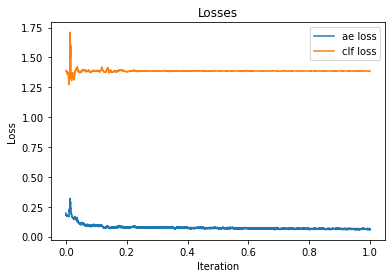

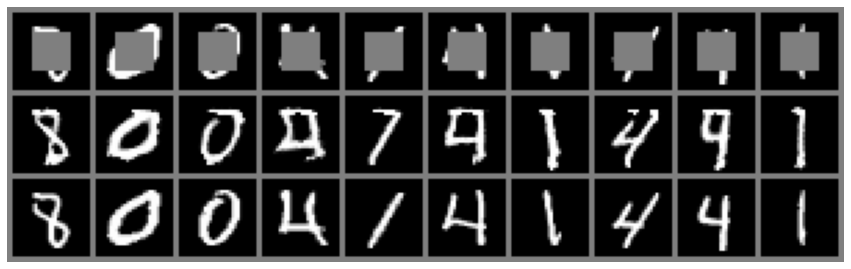

In [30]:
q1_results(q1)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

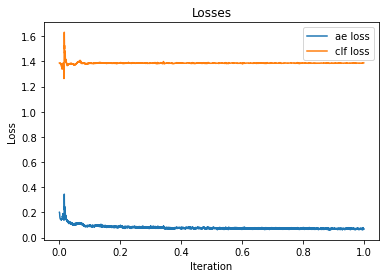

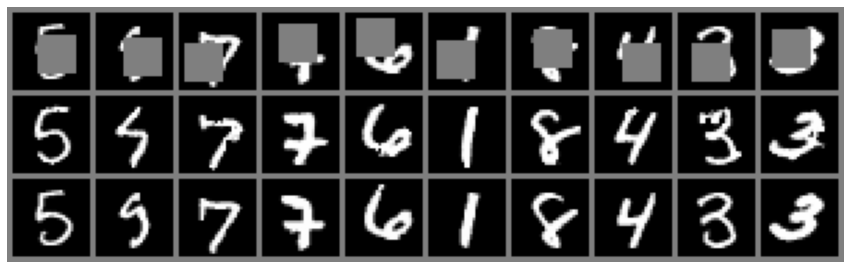

In [22]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [4]:
class Classifier(nn.Module):
    def __init__(self, n_classes: int = 4, hidden_dim: int = 128):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear_block = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x, noise=None):
        batch_size = x.shape[0]
        out = self.conv_block(x)
        out = torch.flatten(out, start_dim=1)

        return self.linear_block(out)

In [5]:
class RotationNet(nn.Module): 
    def __init__(self, n_classes: int = 4, hidden_dim: int = 128): 
        super().__init__()
        self.classifier = Classifier(n_classes, hidden_dim)

    def _calculate_loss(self, batch, labels):
        batch_size = batch.shape[0]

        predicition = self.classifier(batch)
        loss = F.cross_entropy(predicition, labels)

        batch_accuracy = (torch.argmax(predicition, dim=1) == labels).sum()

        return loss.mean(), batch_accuracy

    def fit(self,
            train_dataloader: DataLoader,
            epochs: int = 20,
            lr: float = 1e-3,
            ) -> Tuple[np.ndarray, np.ndarray]:

        losses = []
        accuracy_array = []
        optim = opt.Adam(self.parameters(), lr=lr)

        for epoch in trange(epochs, desc="Training"):
            accuracy = 0
            dataset_size = 0
            for batch, label in train_dataloader:
                dataset_size += batch.shape[0]

                batch = batch.to(device)
                label = label.to(device)
                
                loss, batch_accuracy = self._calculate_loss(batch, label)
                
                optim.zero_grad()
                loss.backward()
                optim.step()

                losses.append(loss.item())
                accuracy += batch_accuracy.item()

            accuracy_array.append(accuracy / dataset_size)

        return np.array(losses), np.array(accuracy_array)

In [6]:
class RotationDataset(Dataset):
    def __init__(
        self,
        image_dataset: Dataset,
        degree_array: List[float] = [0.0, 90.0, 180.0, 270.0]
        ):
      
        super().__init__()

        self.degree_array = degree_array
        
        self.image_dataset = image_dataset

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, index):
        cur_image = self.image_dataset[index][0]

        degree_index = np.random.randint(0, len(self.degree_array))
        degree = self.degree_array[degree_index]

        return T.functional.rotate(cur_image, degree), degree_index

In [7]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """

    batch_size = 256
    epochs = 10
    lr = 1e-3

    degree_array = [0.0, 90.0, 180.0, 270.0]
    hidden_dim = 128

    train_dataset = RotationDataset(train_data, degree_array)
    
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    model = RotationNet(len(degree_array), hidden_dim).to(device)

    losses, accuracy_array = model.fit(train_dataloader, epochs, lr)

    return losses, accuracy_array 

Training:   0%|          | 0/10 [00:00<?, ?it/s]

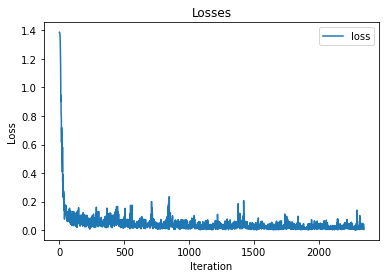

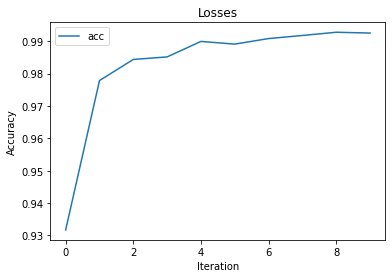

In [9]:
q2_results(q2)